![title](images/header.png)


# Road Network and Travel Time Prediction from Satellite Imagery on a CPU
-----
Automated road network extraction from remote sensing imagery remains a significant challenge despite its importance in a broad array of applications. To this end, we explore road network extraction at scale with inference of semantic features of the graph, identifying speed limits and route travel times for each roadway. We call this approach City-Scale Road Extraction from Satellite Imagery (CRESI). See our [paper](http://openaccess.thecvf.com/content_WACV_2020/papers/Van_Etten_City-Scale_Road_Extraction_from_Satellite_Imagery_v2_Road_Speeds_and_WACV_2020_paper.pdf) for further details on CRESI.

Including estimates for travel time permits true optimal routing (rather than just the shortest geographic distance), which is not possible with existing remote sensing imagery based methods.  Such time-based routing is usually critical to most use cases, and can differ significantly from simple geometric routing (see figure below).

![title](images/routes.png)


This tutorial details the steps required to extract road networks starting from raw satellite imagery on a local laptop (no GPU server required).  We also explore optimized routing techniques that apply these techniques to an example evacuation scenario in a previously unseen city.

This notebook (Part 2) demonstrates the CRESI algorithm, and assumes: 

- The user has already set up the environment via [Part 1](https://github.com/CosmiQ/cresi/tree/master/notebooks/dar_tutorial_cpu/cresi_cpu_part1.ipynb).
- Docker has 6+ GB of Memory and 6+ CPU cores available (edited via the  Preferencees -> Resources menu).
- The local CRESI directory (```cresi_dir``` in Part 1) is mounted in ```/opt/cresi/``` in the docker container.  
- This notebook is using the docker kernel and is accessed via: http://localhost:9111/notebooks/cresi_cpu_part2.ipynb.

In [1]:
# import packages within the docker kernel

import os
import json
import skimage.io
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt



In [18]:
cresi_dir = '/opt/cresi'
src_dir = os.path.join(cresi_dir, 'cresi')
config_dir = os.path.join(cresi_dir, 'cresi/configs')
weight_dir = os.path.join(cresi_dir, 'results/aws_weights')
test_im_raw_dir = os.path.join(cresi_dir, 'test_imagery/dar/PS-MS')
test_im_clip_dir = os.path.join(cresi_dir, 'test_imagery/dar/PS-MS_clip')
test_final_dir = os.path.join(cresi_dir, 'test_imagery/dar/PS-RGB_8bit_clip')
results_root_dir = os.path.join(cresi_dir, 'results')
results_dir = os.path.join(results_root_dir, 'dar_tutorial_cpu')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')
# make dirs
for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir]:
    os.makedirs(d, exist_ok=True)

-----
## 2. Download Data

### A. Model Weights

CRESI provided the algorithmic baseline for the [SpaceNet 5 Challenge](https://spacenet.ai/sn5-challenge/).  While challenge participants managed to improve the perforamnce of the CRESI baseline by about 5%, we will use the original CRESI model for this exercise, as it has by far the fastest runtime (see [this blog](https://medium.com/the-downlinq/spacenet-5-winning-model-release-end-of-the-road-fd02e00b826c) for further details.) Model weights are freely available on AWS.  The [AWS CLI](https://aws.amazon.com/cli/) tool is installed within the docker container, so you once you configure this tool (via ```aws configure```), simply execute the cell below:

In [2]:
!aws s3 cp --recursive s3://spacenet-dataset/spacenet-model-weights/spacenet-5/baseline/ {weight_dir}

download: s3://spacenet-dataset/spacenet-model-weights/spacenet-5/baseline/README.txt to ../../results/aws_weights/README.txt
download: s3://spacenet-dataset/spacenet-model-weights/spacenet-5/baseline/weights/fold0_best.pth to ../../results/aws_weights/weights/fold0_best.pth


### B. Testing Data

Since the pre-trained model weights are available, we need not download the SpaceNet training data.  Instead, we will just download the testing data.  For this exercise, we'll explore SpaceNet Area of Interest (AOI) \#10: Dar Es Salaam.  This city was withheld for testing purposes in SpaceNet 5, meaning that the pre-trained model has not been trained on this city whatsoever.  To download the data (25 GB):

In [16]:
!aws s3 ls --no-sign-request --recursive --human-readable --summarize s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS

2020-02-27 17:23:34   25.9 GiB AOIs/AOI_10_Dar_Es_Salaam/PS-MS/AOI_10_Dar_Es_Salaam_PS-MS_COG.tif

Total Objects: 1
   Total Size: 25.9 GiB


In [ ]:
!aws s3 cp --recursive s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS/ {test_im_raw_dir}

-----
## 3. Prepare Test Data

While CRESI is designed to handle images of arbitrary size and extent, for this exercise we will clip the image somewhat to speed processing time and ease visualization. We will also convert the 8-band multispectral 16-bit image to an easier to visualize 8-bit RGB image. 

In [28]:
# Clip the image extent
ulx, uly, lrx, lry = 39.25252, -6.7580, 39.28430, -6.7880  # v0

im_name = [z for z in os.listdir(test_im_raw_dir) if z.endswith('.tif')][0]
print("im_name:", im_name)
test_im_raw = os.path.join(test_im_raw_dir, im_name)
test_im_tmp = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip.vrt')
print("temp file:", test_im_tmp)
test_im_clip = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip_60cm.tif')
print("output_file:", test_im_clip)

# clip to extent
!gdal_translate -projwin {ulx} {uly} {lrx} {lry} {test_im_raw} {test_im_tmp}

# resample 30 cm imagery to 60 cm
!gdal_translate -outsize 50% 50% {test_im_tmp} {test_im_clip}

im_name: AOI_10_Dar_Es_Salaam_PS-MS_COG.tif
temp file: /opt/cresi/test_imagery/dar/PS-MS_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip.vrt
output_file: /opt/cresi/test_imagery/dar/PS-MS_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
Input file size is 11770, 11111
Input file size is 11770, 11111
0...10...20...30...40...50...60...70...80...90...100 - done.


/opt/cresi/cresi/data_prep
im_files: ['AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif']
bmin, bmax: 0 255
zero_frac =  0.02212771489553378
bmin, bmax: 0 255
zero_frac =  0.020588002725506205
bmin, bmax: 0 255
zero_frac =  0.02011851822395494
Conversion_command list: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-a_nodata', '0', '-co', '"PHOTOMETRIC=rgb"', '-b 1', '-scale_1', '5.0', '255.0', '0', '255', '-b 2', '-scale_2', '5.0', '255.0', '0', '255', '-b 3', '-scale_3', '6.0', '255.0', '0', '255', '/opt/cresi/test_imagery/dar/PS-MS_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif', '/opt/cresi/test_imagery/dar/PS-RGB_8bit_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif']
Conversion_command str: gdal_translate -ot Byte -of GTiff -a_nodata 0 -co "PHOTOMETRIC=rgb" -b 1 -scale_1 5.0 255.0 0 255 -b 2 -scale_2 5.0 255.0 0 255 -b 3 -scale_3 6.0 255.0 0 255 /opt/cresi/test_imagery/dar/PS-MS_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif /opt/cresi/test_imagery/dar/PS-RGB_8bit_clip/AOI_

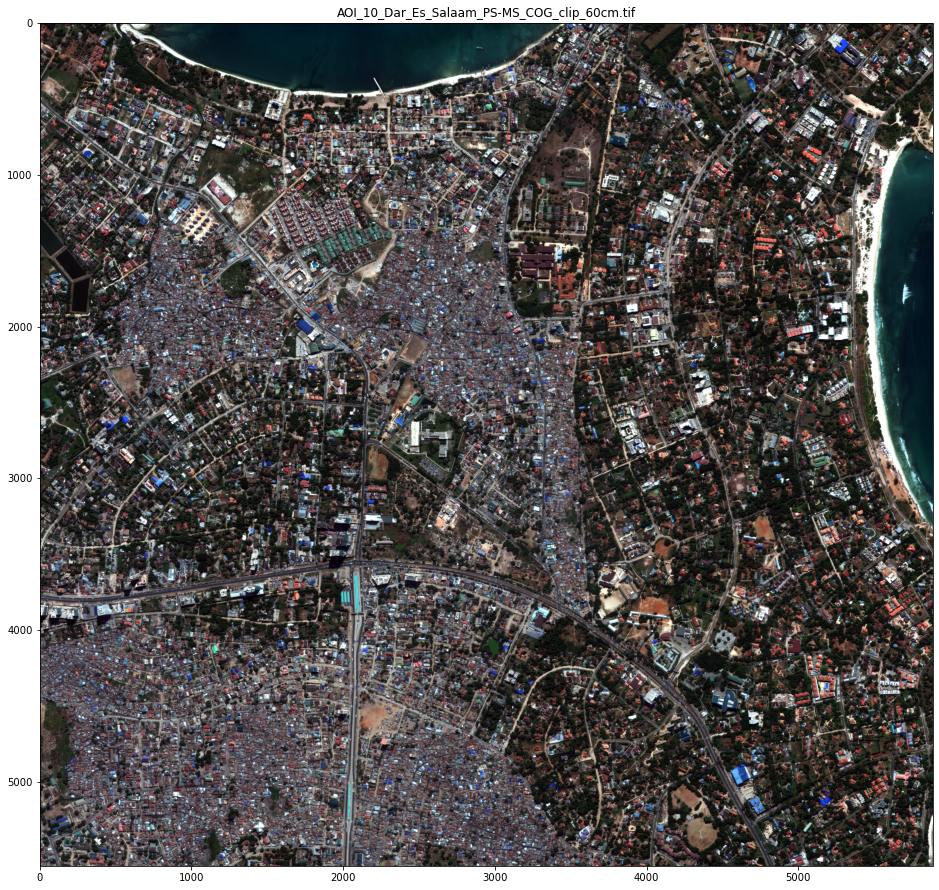

In [38]:
# Convert 16-bit multispectral test data to 8-bit RGB
%cd {os.path.join(cresi_dir, 'cresi/data_prep/')}
import create_8bit_images

create_8bit_images.dir_to_8bit(test_im_clip_dir, test_final_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

# display our test image
fig_width, fig_height = 16, 16
im_test_name = [z for z in os.listdir(test_final_dir) if z.endswith('.tif')][0]
im_test_path = os.path.join(test_final_dir, im_test_name)
im_test = skimage.io.imread(im_test_path)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(im_test)
_ = ax.set_title(im_test_name)

Image stats for /AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif: 

In [40]:
!gdalinfo {test_final_dir}/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif

Driver: GTiff/GeoTIFF
Files: /opt/cresi/test_imagery/dar/PS-RGB_8bit_clip/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
Size is 5885, 5555
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (39.252518999985000,-6.757997400001100)
Pixel Size = (0.000005399999998,-0.000005400486049)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  39.2525190,  -6.7579974) ( 39d15' 9.07"E,  6d45'28.79"S)
Lower Left  (  39.2525190,  -6

-----
## 4. Prepare the config file

CRESI reads from a .json configuration file, and for a pre-trained model executing inference requires only changing a few paths (namely, the testing imagery, model weights, and results paths) in the ```cresi/cresi/configs/dar_tutorial_cpu.json``` file.  These paths should already be set properly, but if not, exectue the cell below.

In [45]:
config_path = os.path.join(config_dir, 'dar_tutorial_cpu.json')
print("config path:", config_path)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    data['path_results_root'] = results_root_dir
    data['speed_conversion_file'] = os.path.join(config_dir, 'speed_conversion_binned7.csv')
    data['save_weights_dir'] = os.path.join(weight_dir, 'weights') 
    data['test_data_refined_dir'] = test_final_dir
    data['test_sliced_dir'] = test_final_dir + '_sliced'
    data['test_results_dir'] = 'dar_tutorial_cpu'
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

print("config data:")
data

config path: /opt/cresi/cresi/configs/dar_tutorial_cpu.json
config data:


{'path_src': '/opt/cresi/cresi',
 'path_results_root': '/opt/cresi/results',
 'speed_conversion_file': '/opt/cresi/cresi/configs/speed_conversion_binned7.csv',
 'save_weights_dir': '/opt/cresi/results/aws_weights/weights',
 'test_data_refined_dir': '/opt/cresi/test_imagery/dar/PS-RGB_8bit_clip',
 'test_sliced_dir': '/opt/cresi/test_imagery/dar/PS-RGB_8bit_clip_sliced',
 'test_results_dir': 'dar_tutorial_cpu',
 'slice_x': 1300,
 'slice_y': 1300,
 'stride_x': 1280,
 'stride_y': 1280,
 'skeleton_thresh': 0.25,
 'min_subgraph_length_pix': 600,
 'min_spur_length_m': 12,
 'rdp_epsilon': 1,
 'log_to_console': 0,
 'train_data_refined_dir_ims': '',
 'train_data_refined_dir_masks': '',
 'folds_file_name': 'folds4.csv',
 'folds_save_dir': 'folds',
 'tile_df_csv': 'tile_df.csv',
 'merged_dir': 'merged',
 'stitched_dir_raw': 'stitched/mask_raw',
 'stitched_dir_count': 'stitched/mask_count',
 'stitched_dir_norm': 'stitched/mask_norm',
 'wkt_submission': 'wkt_submission_nospeed.csv',
 'skeleton_dir':

-----
## 5. Run Inference

The simplest option is to sipmly run the test.sh script (e.g. ```./test.sh configs/dar_tutorial_cpu.json```) which will execute all of the various inference scripts in series.  For this exercise, we will instead run the individual commands to view what's going on at each step.

### 5.1. 02_eval.py 

The 02_eval.py script applies the trained deep learning model to our testing imagery.  First, we tile the imagery into manageable sizes (~800 x 800 meters or 1300 x 1300 pixels). On windows inference proceeds at ~14 seconds per tile, and the entire process completes in 11 minutes for 25 tiles.

While running, you will see a progress bar something like:
```
20%|████████████████████████                                                                                  | 5/25 [02:27<09:42, 29.13s/it]
```

We will kick off inference

In [3]:
%cd {src_dir}
%run -i 02_eval.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Executing inference on the CPU
Run utils.update_config()...
Updated config: OrderedDict([('path_src', '/opt/cresi/cresi'), ('path_results_root', '/opt/cresi/results'), ('save_weights_dir', '/opt/cresi/results/aws_weights/weights'), ('num_channels', 3), ('network', 'resnet34'), ('skeleton_thresh', 0.25), ('use_medial_axis', 0), ('min_subgraph_length_pix', 600), ('min_spur_length_m', 12), ('rdp_epsilon', 1), ('skeleton_band', 7), ('intersection_band', -1), ('early_stopper_patience', 5), ('num_folds', 1), ('default_val_perc', 0.2), ('train_data_refined_dir_ims', ''), ('train_data_refined_dir_masks', ''), ('speed_conversion_file', '/opt/cresi/cresi/configs/speed_conversion_binned7.csv'), ('folds_file_name', 'folds4.csv'), ('test_data_refined_dir', '/opt/cresi/test_imagery/dar/PS-RGB_8bit_clip'), ('test_results_dir', 'dar_tutorial_cpu'), ('test_sliced_dir', '/opt/cresi/test_imagery/dar/PS-RGB_8bit_clip_sliced'), ('slice_x', 1300), ('slice_y', 1300), ('stride_x', 1280), ('st


  0%|          | 0/90 [00:00<?, ?it/s]

  model: Resnet34_upsample(
  (bottlenecks): ModuleList(
    (0): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (decoder_stages): ModuleList(
    (0): UnetDecoderBlock(
      (layer): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): R

100%|██████████| 90/90 [18:03<00:00, 12.04s/it]

Time to run 1 folds for 90 = 1097.2953035831451 seconds


-----
## Intermission: OSM / Commercial Products

One question that often gets asked about approaches like CRESI is: doesn't Google Mapp, Apple Maps, or OpenStreetMap (OSM) already do this? It turns out that there are a number of advantages to a computer vision centric approach, as detailed below.

Commercial products like Google/Apple certainly have a lot of value, but these products often rely upon cell phone GPS pings and infrequently updated imagery for determining real-time routing; in a dynamic scenario (e.g.: natural disaster) existing road networks may be out of date, and cell towers may be down.  Furthermore, the underlaying data is proprietary, further complicating use by practitioners.

Open source offerings such as OSM are similarly useful, though also have limitations.  The crowd-sourced nature of OSM means that updates can take significant time to re-map areas.  For example, it took the Humanitarian OpenStreetMap Team (HOT) over [two months](https://wiki.openstreetmap.org/wiki/2017_Hurricanes_Irma_and_Maria) to fully map Puerto Rico after Hurricane Maria in 2017, even with thousands of volunteers.  

Furthermore, OSM road metadata that can be used to optimize routing is often missing, and road centerline label quality is inconsistent.  For example in the image below there are missing roads on the left, and roads that go through buildings on the right.
<img src="images/osm_goofs.jpg" alt="Drawing" style="height: 200px;"/>

The label inconsistency was explored in Table 3 of our [CRESI paper](http://openaccess.thecvf.com/content_WACV_2020/papers/Van_Etten_City-Scale_Road_Extraction_from_Satellite_Imagery_v2_Road_Speeds_and_WACV_2020_paper.pdf), where we noted significantly reduced road inference performance when using OSM labels versus SpaceNet labels.  

As an example of the sparsity of OSM metadata, we pulled the OSM map for a portion of one of our training cities (Shanghai) below, and colored by the 'maxspeed' tag.  The vast majority of roads have no indicated speed limit.

<br>
<img src="images/shanghai_osm_speed.png" alt="Drawing" style="height: 500px;"/>
<br>

The point here is not to cast aspersions at OSM, which is a great resource, but to point out that there is a need for a rapid machine learning algorithm that can extract precise road centerlines and attendant metadata such as safe travel speed.  

The development of CRESI and administration of the [SpaceNet 5 Challege](https://spacenet.ai/sn5-challenge/) yielded a great many insights into both dataset requirements (e.g. SpaceNet + OSM, varying geographies), as well as algorithmic performance and robustness.  For further analysis of these insights we encourage readers to explore the following blogs:

1. [OSM+Google Imagery](https://medium.com/the-downlinq/computer-vision-with-openstreetmap-and-spacenet-a-comparison-cc70353d0ace)
2. [Neighborhood Comparisons](https://medium.com/the-downlinq/spacenet-5-results-deep-dive-part-2-apls-to-apls-2b1fc7307629)
3. [Predictive Features](https://medium.com/the-downlinq/spacenet-5-results-deep-dive-part-3-the-apls-sauce-378ca0666ca9)
4. [SpaceNet 5 Speed / Performance Comparision](https://medium.com/the-downlinq/spacenet-5-winning-model-release-end-of-the-road-fd02e00b826c)


-----
### 5.1. 02_eval.py (continued)

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

mask_pred.shape: (8, 1300, 1300)


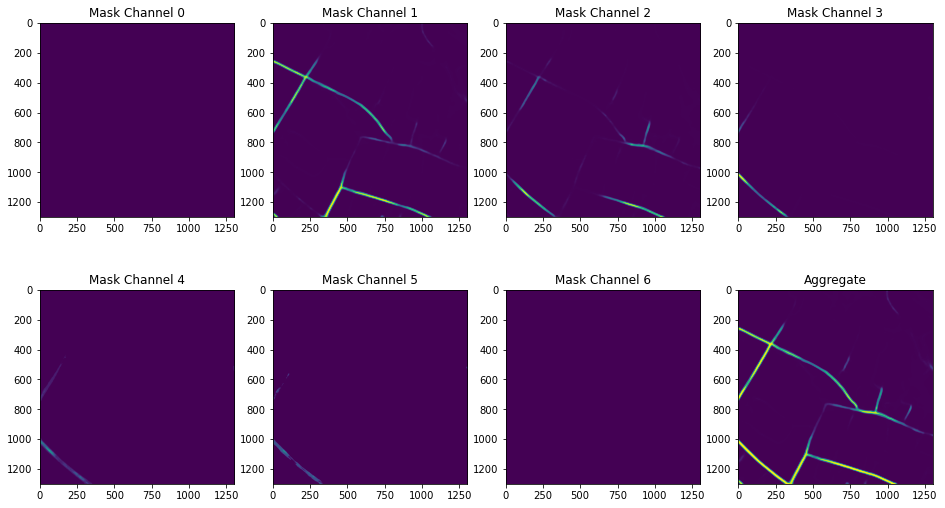

In [4]:
# inspect
mask_pred_file = 'fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__5120__6400__1300__1300__11770__11111.tif'

mask_pred_file = 'fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__0__0__1300__1300__11770__11111.tif'
mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

-----
### 5.2. 03b_stitch.py

The output of 02_eval.py is a series of chipped prediction masks, which we stitch back together (using the procedure illustrated below) in order to produce the aggregate prediction mask.  

<br>
<img src="images/basiss_test.jpg" alt="Drawing" style="height: 500px;"/>
<br>

The command below takes ~20 seconds to run for our test image, and creates the total mask. Many road extraction algorithms end here once a road pixel mask has been produced.  We still have a few more steps to go, however.

In [3]:
%cd {src_dir}
%run -i 03b_stitch.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Running stitch.py...
post_process_image - w, h: 5885 5555
0 / 25
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 4
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 5555, 5885)
mask_norm.dtype: uint8
Time to run stitch.py and create large masks (and save): 7.080386400222778 seconds


mask_pred.shape: (8, 5555, 5885)


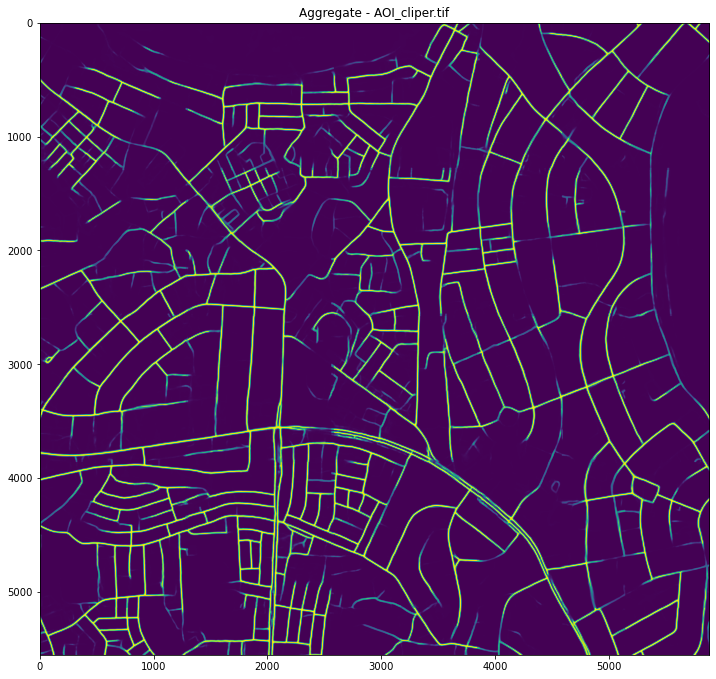

In [4]:
# Inspect the output
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

-----
### 5.3. 04_skeletonize.py

The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

Steps 1-3 are summarized in the figure below:

<br>
<img src="images/skeletonize.png" alt="Drawing" style="height: 180px;"/>
<br>

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed, and should take ~20 seconds to run.

In [5]:
%run -i 04_skeletonize.py configs/dar_tutorial_cpu.json

min_spur_length_pix: 40
Use_medial_axis? False
im_dir: /opt/cresi/results/dar_tutorial_cpu/stitched/mask_norm
out_ske_dir: /opt/cresi/results/dar_tutorial_cpu/skeleton
out_gdir: /opt/cresi/results/dar_tutorial_cpu/sknw_gpickle

 1 / 1 : AOI_cliper.tif
  img_loc: /opt/cresi/results/dar_tutorial_cpu/stitched/mask_norm/AOI_cliper.tif
  im_root: AOI_cliper
  out_ske_file: /opt/cresi/results/dar_tutorial_cpu/skeleton/AOI_cliper.tif
Executing make_skeleton...
make_skeleton(), input img_shape: ()
make_skeleton(), img.shape: (5555, 5885)
make_skeleton(), img.size: 32691175
make_skeleton(), img dtype: uint8
Run preprocess()...


/opt/cresi/cresi/04_skeletonize.py:345: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = (img > (img_mult * thresh)).astype(np.bool)
/opt/cresi/cresi/04_skeletonize.py:346: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
  remove_small_objects(img, hole_size, in_place=True)
/opt/cresi/cresi/04_skeletonize.py:347: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see rem

Time to run preprocess(): 1.1244816780090332 seconds
skeletonize...
Time to run skimage.skeletonize(): 1.0493829250335693 seconds
fix_borders...
Time fix borders: 0.017592430114746094 seconds
ske.shape: (5555, 5885)
Time to run make_skeleton: 2.867858409881592 seconds
Execute sknw...
1158 random node props: {'pts': array([[5552, 5749]], dtype=int16), 'o': array([5552., 5749.])}
Clean out small terminals - round 0
Clean out small terminals - round 0 num nodes: 1159
Clean out small terminals - round 1
Clean out small terminals - round 1 num nodes: 974
Clean out small terminals - round 2
Clean out small terminals - round 2 num nodes: 955
Clean out small terminals - round 3
Clean out small terminals - round 3 num nodes: 954
Clean out small terminals - round 4
Clean out small terminals - round 4 num nodes: 953
len G.nodes(): 953
len G.edges(): 1037
1158 random node props: {'pts': array([[5552, 5749]], dtype=int16), 'o': array([5552., 5749.])}
random edge props for edge: (1130, 1156)  =  {'p

In [6]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

,ImageId,WKT_Pix
0,AOI_cliper,"LINESTRING (3670.0 2.0, 3659.0 31.0, 3641.0 62.0)"
1,AOI_cliper,"LINESTRING (4380.0 2.0, 4395.0 76.0, 4406.0 10..."
2,AOI_cliper,"LINESTRING (5243.0 2.0, 5254.0 28.0)"
3,AOI_cliper,"LINESTRING (5285.0 2.0, 5269.0 23.0, 5254.0 28.0)"
4,AOI_cliper,"LINESTRING (5800.0 2.0, 5785.0 26.0, 5758.0 57.0)"


-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [5]:
%run -i 05_wkt_to_G.py configs/dar_tutorial_cpu.json 

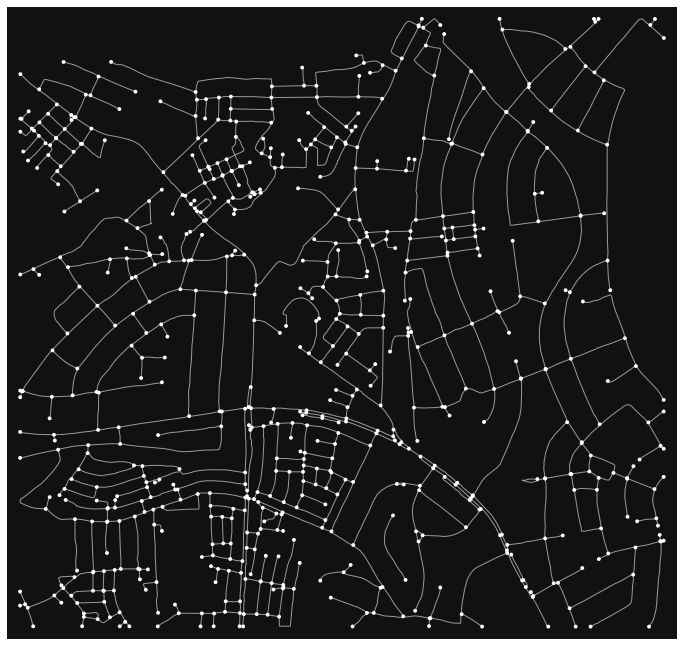

In [6]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))